# Vehicle Routing Problem (VRP)

Here we're going to solve the vehicle routing problem (VRP). This is an exercise in integer programming, so it essentially becomes combinatorial optimization, and large problems quickly become unsolvable, so we'll keep it small. This is actually really similar to the traveling salesman problem (TSP), but with some small modifications.

The formulation of the problem is as follows: we must provide three input variables: a distance/time/cost matrix $D \in \mathbb{R}^{N\times N}$, 

In [1]:
from typing import Union, Iterable

import mipcl_py.mipshell.mipshell as mip
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
class VRP(mip.Problem):
    """MILP problem for modeling the Vehicle Routing Problem
    
    This is a simple version of the VRP where all the vehicles involved have identical
    characteristics (i.e. all the same capacity, costs, etc.). The maximum number of 
    vehicles can be specified, but if there is a way to deliver the goods without using
    all of the vehicles that is more optimal, it will do that, otherwise if the capacity
    constraints cannot be met the problem will be infeasible. You can also specify
    the quantity of goods to be dropped off at each customer; by default this is just 1
    """
    def model(self, D: np.ndarray, K: int, C: float, q: Union[float, Iterable]=1):
        """VRP model definition
        Arguments:
            D [ndarray]: Square matrix (NxN) of distances between locations. It
                is assumed that location 0 is the depot.
            K [int]: The maximum number of vehicles available.
            C [float]: The capacity of each vehicle.
            q Union[float, Iterable]: The quantity of goods dropped off at
                the given locations.
        Returns:
            None
        """
        self.D = D
        self.C = C
        self.K = K
        N = len(D)
        if isinstance(q, (float, int)):
            q = q * np.ones(N-1)
        self.q = q
        
        # Variables
        self._X = X = mip.VarVector((N, N), "X", mip.BIN)
        self._u = u = mip.VarVector((N-1,), "u", mip.INT, lb=0, ub=C-1)
        self._k = k = mip.Var("k", mip.INT, lb=1, ub=K)
        
        # Constraints
        for i in range(1, N):
            mip.sum_(X[i][j] for j in range(N)) == 1
            mip.sum_(X[j][i] for j in range(N)) == 1
            X[i][i] == 0
        X[0][0] == 0
        mip.sum_(X[i][0] for i in range(N)) == k
        mip.sum_(X[0][i] for i in range(N)) == k
        for i in range(1, N):
            for j in range(1, N):
                if i == j:
                    continue
                u[j-1] - u[i-1] >= q[j-1] - C*(1-X[i][j])
        
        # Objective
        obj = mip.sum_(D[i,j]*X[i][j] for i in range(N) for j in range(N))
        mip.minimize(obj)
        
    @property
    def X(self):
        N = len(self._X)
        X = np.array([
            [self._X[i][j].val for j in range(N)] 
        for i in range(N)]).astype(int)
        return X
    
    @property
    def u(self):
        u = self._u
        u = np.array([u[i].val for i in range(len(u))])
        return u.astype(int)
    
    @property
    def routes(self):
        X = self.X
        N = len(X)
        # Destinations after leaving depot
        destinations = np.arange(N)[X[0] == 1]
        # Iterate over routes
        routes = list()
        for d in destinations:
            route = [0, d]
            while True:
                if d == 0:
                    break
                d = np.argmax(X[d])
                route.append(d)
            routes.append(route)
        return routes
    
    def printSolution(self):
        print("Is optimal:", self.is_solutionOptimal)
        print("Total distance:", self.getObjVal())
        print(f"Routes - {int(self._k.val)} out of K={self.K} max:")
        for i, r in enumerate(self.routes):
            print(f"#{i}:", r)

In [59]:
class VRP_relaxed(mip.Problem):
    """MILP problem for modeling the Vehicle Routing Problem
    
    This is a simple version of the VRP where all the vehicles involved have identical
    characteristics (i.e. all the same capacity, costs, etc.). The maximum number of 
    vehicles can be specified, but if there is a way to deliver the goods without using
    all of the vehicles that is more optimal, it will do that, otherwise if the capacity
    constraints cannot be met the problem will be infeasible. You can also specify
    the quantity of goods to be dropped off at each customer; by default this is just 1
    """
    def model(self, D: np.ndarray, K: int, C: float, q: Union[float, Iterable]=1):
        """VRP model definition
        Arguments:
            D [ndarray]: Square matrix (NxN) of distances between locations. It
                is assumed that location 0 is the depot.
            K [int]: The maximum number of vehicles available.
            C [float]: The capacity of each vehicle.
            q Union[float, Iterable]: The quantity of goods dropped off at
                the given locations.
        Returns:
            None
        """
        self.D = D
        self.C = C
        self.K = K
        N = len(D)
        if isinstance(q, (float, int)):
            q = q * np.ones(N-1)
        self.q = q
        
        # Variables
        self._X = X = mip.VarVector((N, N), "X", mip.REAL, lb=0, ub=1)
        self._u = u = mip.VarVector((N-1,), "u", mip.REAL, lb=0, ub=C-1)
        self._k = k = mip.Var("k", mip.REAL, lb=1, ub=K)
        
        # Constraints
        for i in range(1, N):
            mip.sum_(X[i][j] for j in range(N)) == 1
            mip.sum_(X[j][i] for j in range(N)) == 1
            X[i][i] == 0
        X[0][0] == 0
        mip.sum_(X[i][0] for i in range(N)) == k
        mip.sum_(X[0][i] for i in range(N)) == k
        for i in range(1, N):
            for j in range(1, N):
                if i == j:
                    continue
                u[j-1] - u[i-1] >= q[j-1] - C*(1-X[i][j])
        
        # Objective
        obj = (
            mip.sum_(D[i,j]*X[i][j] for i in range(N) for j in range(N))
            + 5*mip.sum_(X[i][j] for i in range(N) for j in range(N))
        )
        mip.minimize(obj)
        
    @property
    def X(self):
        N = len(self._X)
        X = np.array([
            [self._X[i][j].val for j in range(N)] 
        for i in range(N)])#.astype(int)
        return X
    
    @property
    def u(self):
        u = self._u
        u = np.array([u[i].val for i in range(len(u))])
        return u.astype(int)
    
    @property
    def routes(self):
        X = self.X
        N = len(X)
        # Destinations after leaving depot
        destinations = np.arange(N)[X[0] == 1]
        # Iterate over routes
        routes = list()
        for d in destinations:
            route = [0, d]
            while True:
                if d == 0:
                    break
                d = np.argmax(X[d])
                route.append(d)
            routes.append(route)
        return routes
    
    def printSolution(self):
        print("Is optimal:", self.is_solutionOptimal)
        print("Total distance:", self.getObjVal())
        print(f"Routes - {int(self._k.val)} out of K={self.K} max:")
        for i, r in enumerate(self.routes):
            print(f"#{i}:", r)

In [60]:
N = 5 # Number of stops (excluding depot)
K = 5 # Max number of vehicles
C = 5 # Max vehicle capacity
q = np.random.rand(N)
np.random.seed(2)
locations = np.random.randn(N+1, 2)
D = squareform(pdist(locations)) # Distance matrix

prob = VRP_relaxed("VRP")
prob.model(D, K, C, q)
%time prob.optimize(silent=False, timeLimit=60*5, gap=0.0)

CPU times: user 691 µs, sys: 0 ns, total: 691 µs
Wall time: 697 µs


In [61]:
prob.printSolution()

Is optimal: True
Total distance: 30.0
Routes - 1 out of K=5 max:


In [65]:
prob.X.round(2)

array([[ 0.  ,  0.  ,  0.1 ,  0.34,  0.56,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.56,  0.44,  0.  ],
       [ 0.  ,  0.9 ,  0.  ,  0.1 ,  0.  ,  0.  ],
       [-0.  ,  0.1 ,  0.9 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

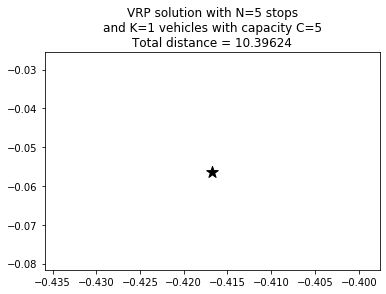

In [47]:
# Plot the solution
# Size of dots denotes the quantity dropped off at each customer
routes = prob.routes
for i, route in enumerate(routes):
    r = np.array(route)-1; r = r[r>=0]
    s = 100*q[r]
    c = f"C{i}"
    route = locations[route]
    first = True
    for s, r in zip(s, route):
        if first:
            first = False
            continue
        plt.scatter(*r, c=c, s=s, marker='o', zorder=0)
    plt.plot(*route.T, color=c, marker=None, zorder=0)
plt.scatter(*locations[0], s=150, marker="*", color='black', zorder=1)
plt.title(f"VRP solution with N={N} stops\n"
          f"and K={int(prob._k.val)} vehicles with capacity C={C}\n"
          f"Total distance = {prob.getObjVal():.5f}")
plt.show()